# Install Libraries

In [1]:
"""# Base packages
!pip install pandas numpy matplotlib yfinance

# Advanced tools
!pip install backtrader backtesting ta pypfopt fredapi

# Dashboard dependencies
!pip install plotly dash ipywidgets

# Version control helper
!pip install jupyterlab-git"""

'# Base packages\n!pip install pandas numpy matplotlib yfinance\n\n# Advanced tools\n!pip install backtrader backtesting ta pypfopt fredapi\n\n# Dashboard dependencies\n!pip install plotly dash ipywidgets\n\n# Version control helper\n!pip install jupyterlab-git'

## API testing

In [2]:
import pandas as pd
import yfinance as yf
from fredapi import Fred

# Test Yahoo Finance
spy = yf.download('SPY', start='2020-01-01', end='2025-01-01')
print(spy.head())

# Test FRED API
fred = Fred(api_key='0842c39f686c08ea04686ec02c058bb7')  # Get key: https://fred.stlouisfed.org/docs/api/api_key.html
cpi = fred.get_series('CPIAUCSL')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2020-01-02  300.291595  300.310100  298.128634  299.062230  59151200
2020-01-03  298.017761  299.154715  296.806873  296.862331  77709700
2020-01-06  299.154633  299.237820  296.122758  296.242927  55653900
2020-01-07  298.313416  299.062132  297.860468  298.581455  40496400
2020-01-08  299.903351  301.132716  298.258020  298.507583  68296000


In [3]:
cpi.tail()

2024-10-01    315.564
2024-11-01    316.449
2024-12-01    317.603
2025-01-01    319.086
2025-02-01    319.775
dtype: float64

## data_pipeline.py

In [4]:
# data_pipeline.py
import pandas as pd
import yfinance as yf
from fredapi import Fred
import pandas_ta as ta  # More reliable than standalone ta library
from datetime import datetime
import matplotlib.pyplot as plt

def fetch_market_data(tickers=['SPY', 'QQQ'], 
                     start_date='2010-01-01',
                     end_date=datetime.today().strftime('%Y-%m-%d')):
    """
    Fetch OHLC data for multiple tickers with error handling
    """
    try:
        data = yf.download(
            tickers=tickers,
            start=start_date,
            end=end_date,
            interval='1d',
            group_by='ticker',
            progress=False,
            auto_adjust=True  # Use adjusted closing prices
        )
        print(f"Successfully downloaded data for {tickers}")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

def fetch_macro_data(api_key, series_ids=['VIXCLS']):
    """
    Fetch macroeconomic data from FRED with validation
    """
    if api_key == '0fdaaf241f7b0172d081258647168bb4':
        raise ValueError("Please obtain a FRED API key from https://research.stlouisfed.org/docs/api/api_key.html")
    
    fred = Fred(api_key=api_key)
    macro_data = pd.DataFrame()
    
    for series_id in series_ids:
        try:
            series = fred.get_series(series_id)
            macro_data[series_id] = series
            print(f"Added {series_id} series")
        except Exception as e:
            print(f"Failed to fetch {series_id}: {e}")
    
    return macro_data.dropna()

def calculate_technical_indicators(df, tickers):
    """
    Calculate technical indicators for each ticker with validation
    """
    indicators_df = pd.DataFrame()
    
    for ticker in tickers:
        try:
            # Extract data for current ticker
            ticker_data = df[ticker].copy()
            
            # Calculate indicators using pandas_ta
            ticker_data['RSI_14'] = ta.rsi(ticker_data['Close'], length=14)
            
            # MACD with explicit column naming
            macd = ta.macd(ticker_data['Close'], fast=12, slow=26)
            ticker_data['MACD_12_26'] = macd['MACD_12_26_9']
            
            # Bollinger Bands with proper column handling
            bbands = ta.bbands(ticker_data['Close'], length=20, std=2)
            ticker_data['BBL_20_2'] = bbands['BBL_20_2.0']
            ticker_data['BBU_20_2'] = bbands['BBU_20_2.0']
            
            ticker_data['ATR_14'] = ta.atr(
                ticker_data['High'], 
                ticker_data['Low'], 
                ticker_data['Close'], 
                length=14
            )
            
            # Add ticker prefix to columns
            ticker_data.columns = [f"{ticker}_{col}" for col in ticker_data.columns]
            
            indicators_df = pd.concat([indicators_df, ticker_data], axis=1)
        except KeyError:
            print(f"Ticker {ticker} not found in data")
            continue
            
    return indicators_df.dropna()



def merge_datasets(price_data, macro_data):
    """
    Merge price data with macroeconomic data on date index
    """
    full_data = price_data.join(macro_data, how='inner')
    
    # Forward-fill missing values (appropriate for financial data)
    full_data.ffill(inplace=True)
    full_data.dropna(inplace=True)
    
    return full_data

def visualize_data(df, ticker='SPY'):
    """
    Generate preliminary visualization of key metrics
    """
    plt.figure(figsize=(14, 8))
    
    # Plot closing price with Bollinger Bands
    df[[
        f'{ticker}_Close',
        f'{ticker}_BBL_20_2',
        f'{ticker}_BBU_20_2'
    ]].plot(title=f'{ticker} Closing Price with Bollinger Bands')
    
    plt.figure(figsize=(14, 5))
    df[f'{ticker}_RSI_14'].plot(title='RSI', color='purple')
    plt.axhline(30, linestyle='--', color='green')
    plt.axhline(70, linestyle='--', color='red')
    
    plt.show()
    


Successfully downloaded data for ['SPY', 'QQQ']
Added VIXCLS series
Saved merged dataset to trading_dataset.csv


<Figure size 1400x800 with 0 Axes>

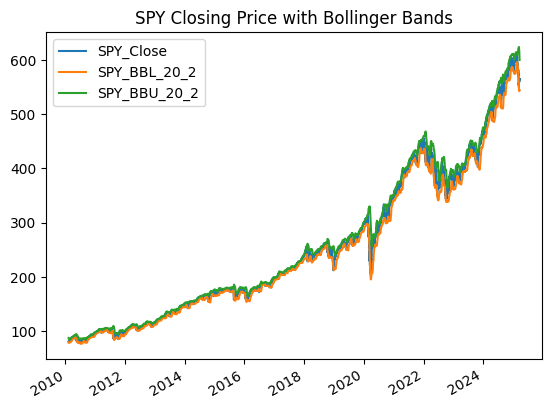

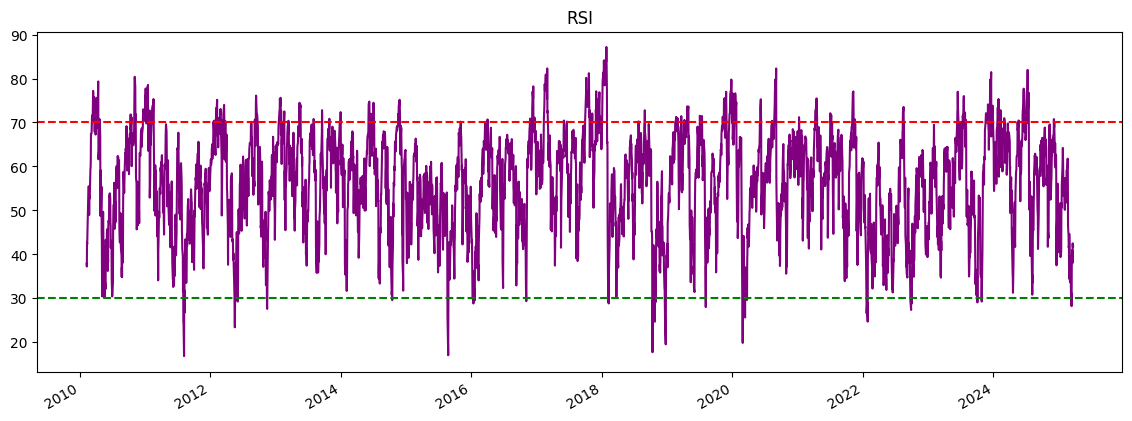


Final dataset sample:


In [5]:
# Main execution flow
if __name__ == "__main__":
    # 1. Fetch data
    price_data = fetch_market_data()
    
    # 2. Get FRED data (replace with your API key)
    macro_data = fetch_macro_data(api_key='854f00b7d1dc742e9691581630452979')
    
    # 3. Calculate technical indicators
    technicals = calculate_technical_indicators(price_data, ['SPY', 'QQQ'])
    
    # 4. Merge datasets
    merged_data = merge_datasets(technicals, macro_data)
    
    # 5. Save cleaned data
    merged_data.to_csv('trading_dataset.csv')
    print("Saved merged dataset to trading_dataset.csv")
    
    # 6. Visualize sample data
    visualize_data(merged_data)
    
    # Show final dataset structure
    print("\nFinal dataset sample:")

In [6]:
merged_data.tail(3)

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_RSI_14,SPY_MACD_12_26,SPY_BBL_20_2,SPY_BBU_20_2,SPY_ATR_14,...,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume,QQQ_RSI_14,QQQ_MACD_12_26,QQQ_BBL_20_2,QQQ_BBU_20_2,QQQ_ATR_14,VIXCLS
2025-03-19,561.141986,569.237628,559.945573,565.429077,66556000,42.474441,-9.986654,542.971570,608.839545,9.842078,...,484.607311,474.162895,480.173950,40430300,40.697011,-11.997114,455.716888,532.963727,11.189526,19.90
2025-03-20,561.640511,568.858788,560.912659,563.794006,62958200,41.600824,-9.475738,543.988988,603.346590,9.706653,...,483.828457,475.470925,478.546356,36780500,39.944797,-11.515770,457.477834,525.414417,10.987240,19.80
2025-03-21,559.280029,564.890015,558.030029,563.979980,83763000,41.747584,-8.952627,544.244272,599.675234,9.503320,...,480.892835,472.205809,480.123993,42234900,41.081575,-10.881563,458.693134,519.681853,10.822939,19.28
